In [8]:
import sys
sys.path.append('../../numpy/1D')

from utils import *
from env import *
from model import *
from matplotlib import gridspec

In [9]:
# set directory to folder with model trained with different place field parameter combinations
data_dir = "/Users/mganeshkumar/Library/CloudStorage/OneDrive-HarvardUniversity/Code/online_pf_learning/online/1D/"

In [3]:
def norm_col(A):
    A_norm = np.zeros_like(A, dtype=float)
    # Normalize each column
    for i in range(A.shape[1]):
        col_min = np.min(A[:, i])
        col_max = np.max(A[:, i])
        A_norm[:, i] = (A[:, i] - col_min) / (col_max - col_min)
    return A_norm

def plot_active_frac_(logparams,total_trials, stable_perf,num,ax=None):
    if ax is None:
        f,ax = plt.subplots()

    trials = np.linspace(stable_perf, total_trials,num,dtype=int)
    xs = np.linspace(-1,1,1001)
    active_fraction = []
    for threshold in [0.01, 0.05, 0.1]:
        af = []
        for trial in trials:
            pcs = predict_batch_placecell(logparams[trial], xs)
            af.append(np.mean(pcs,axis=0)>threshold)
        active_fraction.append(np.mean(np.array(af),axis=1))

    ax.plot(trials, np.mean(np.array(active_fraction),axis=0))
    ax.set_ylabel('Field Active Fraction')
    ax.set_ylim([0.0,1.0])

def plot_activity_activefrac_drift(logparams, total_trials, stable_perf,num, ax, ax2):

    trials = np.linspace(stable_perf, total_trials,num,dtype=int)
    xs = np.linspace(-1,1,1001)
    param_delta = get_param_changes(logparams, total_trials, stable_perf)
    param_delta = param_delta[:3]
    # deltas = np.sum(np.std(param_delta,axis=1),axis=0)
    print(param_delta[0].shape)

    variance_acrosstrials = []
    for trial in trials:
        variance_acrosstrials.append([param_delta[0][trial-stable_perf-1],param_delta[1][trial-stable_perf-1],param_delta[2][trial-stable_perf-1]])
    variance_acrosstrials = np.array(variance_acrosstrials)
    print(variance_acrosstrials.shape)
    deltas = np.sum(np.std(variance_acrosstrials,axis=0),axis=0)
    print(deltas.shape)

    active_fraction_acrosstrials = []
    field_activity = []
    for threshold in [0.25,0.5,1]:
        af = []
        activity = []
        for trial in trials:
            pcs = predict_batch_placecell(logparams[trial], xs)
            af.append(np.mean(pcs,axis=0)>threshold)
            activity.append(np.mean(pcs,axis=0))

        active_fraction_acrosstrials.append(np.mean(np.array(af),axis=0)) # average over trials
        field_activity.append(np.mean(np.array(activity),axis=0)) # average over trials

    mean_active_fraction = np.mean(np.array(active_fraction_acrosstrials),axis=0) # average over thresholds
    mean_activity = np.mean(np.array(field_activity),axis=0) # average over thresholds
    ax.scatter(mean_activity, mean_active_fraction)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_activity).reshape(-1), np.array(mean_active_fraction).reshape(-1))
    regression_line = slope * np.array(mean_activity).reshape(-1) + intercept
    ax.plot(np.array(mean_activity).reshape(-1), regression_line, color='green', label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
    ax.legend(frameon=False,loc=1)
    ax.set_ylabel(f'Fraction of field active time')
    ax.set_xlabel('Mean Field Activity')

    ax2.scatter(mean_activity, deltas)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_activity).reshape(-1), np.array(deltas).reshape(-1))
    regression_line = slope * np.array(mean_activity).reshape(-1) + intercept
    ax2.plot(np.array(mean_activity).reshape(-1), regression_line, color='green', label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
    ax2.legend(frameon=False,loc=1)
    ax2.set_ylabel(f'Variance in field activity')

    print(deltas.shape)

    ax2.plot()

def plot_amplitude_drift_(logparams, total_trials, stable_perf, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    param_delta = get_param_changes(logparams, total_trials, stable_perf)
    param_delta = param_delta[:3]
    mean_amplitude = np.mean(param_delta[2]**2,axis=0)

    delta_lambda = np.std(param_delta[0],axis=0)
    delta_alpha = np.std(param_delta[2]**2,axis=0)
    delta_sigma = np.std(param_delta[1]**2,axis=0)
    deltas_ = delta_lambda + delta_sigma + delta_alpha
    deltas = np.sum(np.std(param_delta,axis=1),axis=0)

    ax.scatter(mean_amplitude, deltas)
    if np.std(mean_amplitude) != 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_amplitude).reshape(-1), np.array(deltas).reshape(-1))
        regression_line = slope * np.array(mean_amplitude).reshape(-1) + intercept
        ax.plot(np.array(mean_amplitude).reshape(-1), regression_line, color='red', label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
    ax.legend(frameon=False,loc=0,fontsize=8)
    ax.set_xlabel('$<\\alpha>$')
    ax.set_ylabel(f'$\sum Var(\\theta)$')

def plot_amplitude_drift(logparams, total_trials, stable_perf,color, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    param_delta = get_param_changes(logparams, total_trials, stable_perf)
    param_delta = param_delta[:3]
    mean_amplitude = np.mean(param_delta[2]**2,axis=0)

    deltas = np.sum(np.std(param_delta,axis=1),axis=0)

    ax.scatter(mean_amplitude, deltas, color=color)
    if np.std(mean_amplitude) != 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_amplitude).reshape(-1), np.array(deltas).reshape(-1))
        regression_line = slope * np.array(mean_amplitude).reshape(-1) + intercept
        ax.plot(np.array(mean_amplitude).reshape(-1), regression_line, color=color, label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
    ax.legend(frameon=False,loc=0,fontsize=8)
    ax.set_xlabel('$<\\alpha>$')
    ax.set_ylabel(f'$\sum Var(\\theta)$')

def plot_amplitude_activefrac(logparams, total_trials, stable_perf,color, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    param_delta = get_param_changes(logparams, total_trials, stable_perf)
    param_delta = param_delta[:3]
    mean_amplitude = np.mean(param_delta[2]**2,axis=0)

    active_fraction = []
    for threshold in [0.05, 0.1,0.25]:
        active_fraction.append(np.mean(param_delta[2]**2 > threshold,axis=0))
    mean_active_fraction = np.mean(np.array(active_fraction),axis=0)

    ax.scatter(mean_amplitude, mean_active_fraction,color=color)
    if np.std(mean_amplitude) != 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_amplitude).reshape(-1), np.array(mean_active_fraction).reshape(-1))
        regression_line = slope * np.array(mean_amplitude).reshape(-1) + intercept
        ax.plot(np.array(mean_amplitude).reshape(-1), regression_line,color=color, label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')

    ax.legend(frameon=False,loc=0, fontsize=8)
    ax.set_xlabel('$<\\alpha>$')
    ax.set_ylabel(f'Fraction Active Time')

def plot_active_frac(logparams,total_trials, stable_perf,color, ax=None):
    if ax is None:
        f,ax = plt.subplots()

    param_delta = get_param_changes(logparams, total_trials,stable_perf)
    active_fraction = []
    for threshold in [0.05, 0.1,0.25]:
        active_fraction.append(np.mean(param_delta[2]**2>threshold,axis=1))
    active_fraction = np.array(active_fraction)

    ax.plot(np.arange(stable_perf, total_trials), np.mean(np.array(active_fraction),axis=0),color=color, )
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'Active Fraction')
    ax.set_ylim([0.0,1.0])



In [4]:
# plot avg latencys in 1 fig

noises = [0.0, 1e-4, 2.5e-4, 5e-4, 1e-3]
pidx = '012'
npc = 64
seeds = 10

allg = []
all_pv = []
all_rep = []
all_params = []

for i, noise in enumerate(noises):

    gs = []
    pvs = []
    reps = []
    params = []

    for seed in range(seeds):

        exptname = f"/data/drift_dyn/dyn_full_1D_td_online_{noise}ns_{pidx}p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_rand_0.5a_0.1s_2a_{seed}s_200000e_5rmax_0.05rsz"
        # exptname = f"./data/drift_dyn/dyn_full_1D_td_0.5sc_2.0ac_{noise}ns_{pidx}p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_rand_0.5a_0.1s_2a_{seed}s_200000e_5rmax_0.05rsz"
                    
        [cum_rewards, trials, pv_corr,rep_corr, param_delta] = saveload(data_dir+exptname, 1, 'load')

        print(seed, noise)

        pd = np.concatenate([np.array(param_delta[:3]), np.sum(np.array(param_delta[3])**2,axis=2)[None,:,:], np.array(param_delta[4])[None,:,:,0]],axis=0)

        gs.append(cum_rewards)
        pvs.append(pv_corr)
        reps.append(rep_corr)
        params.append(pd[:,::100,:])
    
    allg.append(np.array(gs))
    all_pv.append(np.array(pvs))
    all_rep.append(np.array(reps))
    all_params.append(np.array(params))

allg = np.array(allg)
all_pv = np.array(all_pv)
all_rep = np.array(all_rep)
all_params = np.array(all_params)
print(allg.shape, all_pv.shape, all_rep.shape, all_params.shape)
    

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
0 0.0001
1 0.0001
2 0.0001
3 0.0001
4 0.0001
5 0.0001
6 0.0001
7 0.0001
8 0.0001
9 0.0001
0 0.00025
1 0.00025
2 0.00025
3 0.00025
4 0.00025
5 0.00025
6 0.00025
7 0.00025
8 0.00025
9 0.00025
0 0.0005
1 0.0005
2 0.0005
3 0.0005
4 0.0005
5 0.0005
6 0.0005
7 0.0005
8 0.0005
9 0.0005
0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
(5, 10, 200000) (5, 10, 101) (5, 10, 101) (5, 10, 5, 1750, 64)


$\sigma_{noise}=0.0$
$\sigma_{noise}=0.0001$
$\sigma_{noise}=0.00025$
$\sigma_{noise}=0.0005$
$\sigma_{noise}=0.001$


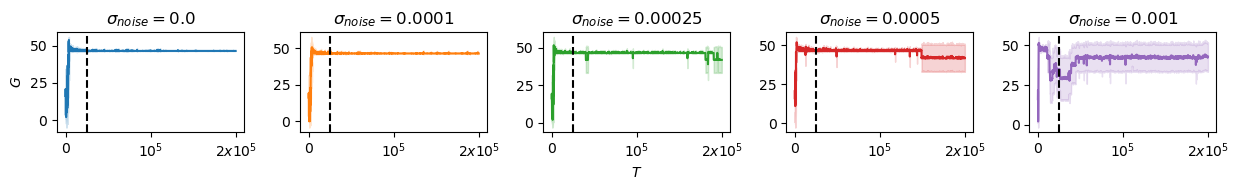

In [ ]:
# plot avg latencys in 1 fig
downsample = 100
T = allg.shape[2]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple']

# Create a figure
f,axs = plt.subplots(1,len(noises), figsize=(12.5, 2))


for i, noise in enumerate(noises):
    color = colors[i]

    label = f"$\sigma_{{noise}}={noises[i]}$"
    print(label)

    meang = np.mean(allg[i],axis=0)[::downsample]
    cig = np.std(allg[i],axis=0)/np.sqrt(seeds) *1.96
    cig = cig[::downsample]  
    x = np.arange(T)[::downsample]

    axs[i].plot(x,meang, label=label, color=color)
    axs[i].fill_between(x,meang-cig, meang+cig,alpha=0.2, color=color)
    axs[i].axvline(25000, color='k',linestyle='--')
    axs[i].set_title(label)
    if i == 0:
        axs[i].set_ylabel('$G$')
    if i == 2:
        axs[i].set_xlabel('$T$') 

    x_ticks = [0,100000, 200000]
    x_ticks_labels = ['$0$', '$10^5$', '$2x10^5$']
    axs[i].set_xticks(x_ticks)
    axs[i].set_xticklabels(x_ticks_labels)

    # x_ticks = ["$0$", "$2e5$"]
    # ax1.set_xticks(x_ticks)
    # ax1.set_xticklabels(x_ticks)

# plt.subplots_adjust(hspace=0.01)  # Reduce the horizontal space

# Adjust the spacing between subplots


f.tight_layout() 
# Show the plot
# f.savefig("./svgs/1D_noises_G_all.svg")


(640,) (640,)
(640,) (640,)
(640,) (640,)
(638,) (638,)
(565,) (565,)


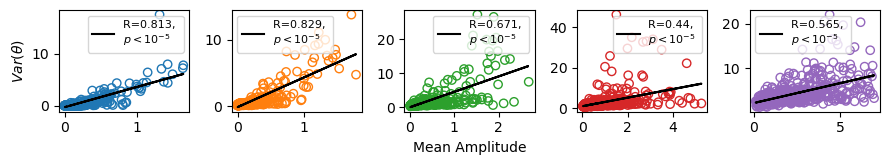

In [ ]:
# plot variance

# Create a figure
f,axs = plt.subplots(1,len(noises), figsize=(9, 1.75))

for i,idx in enumerate(noises):
    color = colors[i]

    label = f"$\sigma_{{noise}}={noises[i]}$"

    sumv = np.sum(np.std(all_params[i],axis=2),axis=1).reshape(-1)

    meanamp = np.mean(all_params[i,:,2]**2,axis=1).reshape(-1)


    meanamp_nonoutliers = meanamp < 7#meanamp.max()*1.1
    meanamp = meanamp[meanamp_nonoutliers]
    sumv = sumv[meanamp_nonoutliers]
    
    # sumv = np.sum(np.std(np.mean(all_params[idx],axis=0),axis=1),axis=0)

    # meanamp = np.mean(np.mean(all_params[idx,:,2],axis=1)**2,axis=0)

    print(sumv.shape, meanamp.shape)

    # Create the first subplot
    axs[i].scatter(meanamp,sumv, color=color, facecolors='none')

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(meanamp).reshape(-1), np.array(sumv).reshape(-1))
    regression_line = slope * np.array(meanamp).reshape(-1) + intercept
    if p_value< 1e-5:
        p = '$p<10^{-5}$'
    elif p_value< 1e-4:
        p = '$p<10^{-4}$'
    elif p_value< 1e-3:
        p = '$p<10^{-3}$'
    else:
        p = f"p={np.round(p_value, 3)}"
    axs[i].plot(np.array(meanamp).reshape(-1), regression_line,color='k', label=f'R={np.round(r_value, 3)}, \n{p}')
    axs[i].legend(frameon=True, fontsize=8)
    # axs[i].set_title(label)


axs[0].set_ylabel('$Var(\\theta)$')
axs[2].set_xlabel('Mean Amplitude')
f.tight_layout() 

# Show the plot
# f.savefig("./svgs/1D_noises_var_amp_all.svg")

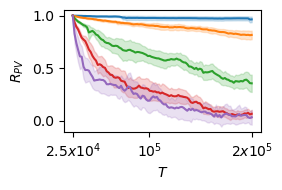

In [ ]:
# plot PV
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple']
f,ax = plt.subplots(figsize=(3,2))

for i,noise in enumerate(noises):
    meanpv = np.mean(all_pv[i],axis=0)
    cipv = 1.96 * np.std(all_pv[i],axis=0)/np.sqrt(seeds)

    ax.plot(trials, meanpv, color=colors[i])
    ax.fill_between(trials, meanpv-cipv, meanpv + cipv, alpha=0.2,color=colors[i])

ax.set_ylabel('$R_{PV}$')
ax.set_xlabel('$T$')

x_ticks = [25000,100000, 200000]
x_ticks_labels = ['$2.5x10^4$', '$10^5$', '$2x10^5$']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_labels)

f.tight_layout()
# f.savefig("./svgs/1D_noises_rpv_all.svg")

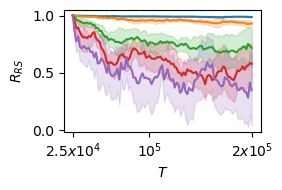

In [ ]:
# plot PV

f,ax = plt.subplots(figsize=(3,2))
for i,noise in enumerate(noises):
    meanrv = np.mean(all_rep[i],axis=0)
    cirv = 1.96 * np.std(all_rep[i],axis=0)/np.sqrt(seeds)

    ax.plot(trials, meanrv, color=colors[i])
    ax.fill_between(trials, meanrv-cirv, meanrv + cirv, alpha=0.2,color=colors[i])

ax.set_ylabel('$R_{RS}$')
ax.set_xlabel('$T$')

x_ticks = [25000,100000, 200000]
x_ticks_labels = ['$2.5x10^4$', '$10^5$', '$2x10^5$']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_labels)

f.tight_layout()
# f.savefig("./svgs/1D_noises_rrs_all.svg")

(10, 1750)
(10, 1750)
(10, 1750)
(10, 1750)
(10, 1750)


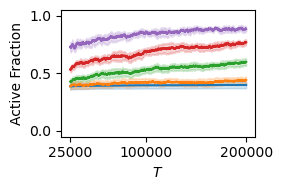

In [ ]:
# plot AF
thresholds = [0.05, 0.1,0.25]
downsample = 100
f,ax = plt.subplots(figsize=(3,2))
for i,noise in enumerate(noises):

    af = []
    for threshold in thresholds:
        af.append(np.mean(all_params[i,:,2,:,:]**2>threshold,axis=2))
    af = np.mean(np.array(af),axis=0)

    print(af.shape)


    meanaf = np.mean(af,axis=0)#[::downsample]
    ciaf = 1.96 * np.std(af,axis=0)/np.sqrt(seeds)
    # ciaf = ciaf[::downsample]
    trs = np.arange(25000,T)[::downsample]

    ax.plot(trs, meanaf, color=colors[i])
    ax.fill_between(trs, meanaf-ciaf, meanaf + ciaf, alpha=0.2,color=colors[i])

ax.set_ylabel('Active Fraction')
ax.set_xlabel('$T$')
ax.set_ylim([-0.05,1.05])
x_ticks = [25000, 100000, 200000]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks)

f.tight_layout()
# f.savefig("./svgs/1D_noises_af_trials_all.svg")

(640,) (640,)
(640,) (640,)
(640,) (640,)
(640,) (640,)
(640,) (640,)


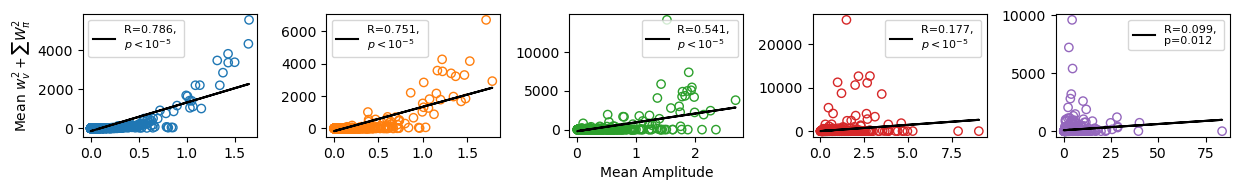

In [ ]:
# plot amp vs activity
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple']
# Create a figure
f,axs = plt.subplots(1,len(noises), figsize=(12.5, 2))

for i,idx in enumerate(noises):
    color = colors[i]

    label = f"$\sigma_{{noise}}={noises[i]}$"

    sumv = all_params[i,:,3]**2 + all_params[i,:,4]**2 # sum wpi + wv
    sumv = np.mean(sumv,axis=1).reshape(-1)

    meanamp = np.mean(all_params[i,:,2]**2,axis=1).reshape(-1)


    meanamp_nonoutliers = meanamp < meanamp.max()*1.1
    meanamp = meanamp[meanamp_nonoutliers]
    sumv = sumv[meanamp_nonoutliers]
    
    # sumv = np.sum(np.std(np.mean(all_params[idx],axis=0),axis=1),axis=0)

    # meanamp = np.mean(np.mean(all_params[idx,:,2],axis=1)**2,axis=0)

    print(sumv.shape, meanamp.shape)

    # Create the first subplot
    axs[i].scatter(meanamp,sumv, color=color, facecolors='none')

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(meanamp).reshape(-1), np.array(sumv).reshape(-1))
    regression_line = slope * np.array(meanamp).reshape(-1) + intercept
    if p_value< 1e-5:
        p = '$p<10^{-5}$'
    elif p_value< 1e-4:
        p = '$p<10^{-4}$'
    elif p_value< 1e-3:
        p = '$p<10^{-3}$'
    else:
        p = f"p={np.round(p_value, 3)}"
    axs[i].plot(np.array(meanamp).reshape(-1), regression_line,color='k', label=f'R={np.round(r_value, 3)}, \n{p}')
    axs[i].legend(frameon=True, fontsize=8)
    # axs[i].set_title(label)


axs[0].set_ylabel('Mean $w_v^2 + \sum W_\pi^2$')
axs[2].set_xlabel('Mean Amplitude')
f.tight_layout() 

# Show the plot
# f.savefig("./svgs/1D_noises_weights_amp_all.svg")



## data

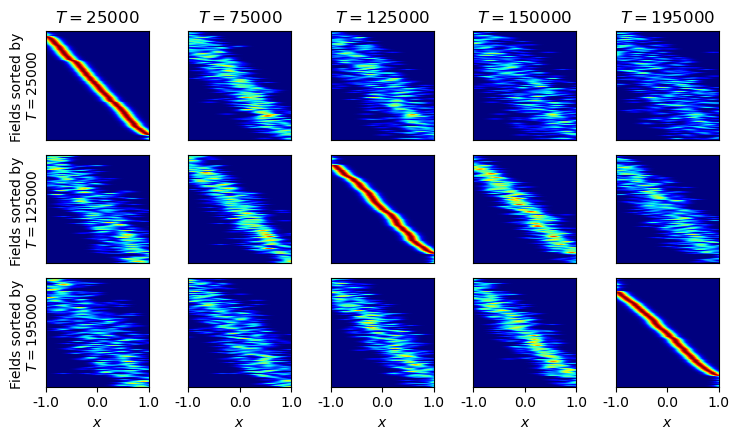

In [ ]:
ns = 2
trials = [0, 1000, 1700]
xs = np.linspace(-1,1,1001)

coms = np.zeros([3, npc, 10], dtype=int)

for seed in range(10):
    for t, trial in enumerate(trials):

        #np.ones(64)*0.1

        param = [all_params[ns, seed, 0, trials[t]], np.ones(64)*0.1, np.ones(64), all_params[ns, seed, 3, trials[t]], all_params[ns, seed, 4, trials[t]]]

        pcact = predict_batch_placecell(param, xs)

        coms[t,:,seed] = np.argmax(pcact,axis=0)

sorted_coms = np.argsort(coms.reshape([3,npc*10]), axis=1)



newtrials = [0,500, 1000, 1250, 1700]

pcacts = np.zeros([5, 1001, npc, 10])

for seed in range(10):
    for t, trial in enumerate(newtrials):
        params = [all_params[ns, seed, 0, trial], np.ones(64)*0.1, np.ones(64), all_params[ns, seed, 3, trial], all_params[ns, seed, 4, trial]]

        pcacts[t, :,:,seed] = predict_batch_placecell(params, xs) 
pcacts = pcacts.reshape([5, 1001, npc*10])


f,ax = plt.subplots(3,5,figsize=(1.5*5, 1.5*3))
for t, trial in enumerate(newtrials):
    for i in range(3):
        im = ax[i,t].imshow((pcacts[t].T)[sorted_coms[i]], aspect='auto',cmap='jet')

        ax[i,t].set_xticks([])
        ax[i,t].set_yticks([])

        if t == 0:
            ax[i,t].set_ylabel(f'Fields sorted by \n$T={trials[i]*100+25000}$')
        if i == 2:
            ax[i,t].set_xlabel('$x$')
            ax[i,t].set_xticks(np.linspace(0,1001,3),np.linspace(-1,1,3))
        if i == 0:
            ax[i,t].set_title(f'$T={trial*100+25000}$')
        
        # if i == 1 and j == 4:
        #     plt.colorbar(im, ax=ax[i,t])

f.tight_layout()
# f.savefig('./svgs/ziv_sort_order_com.svg')

[1, 5, 10, 25, 100, 500, 1000]


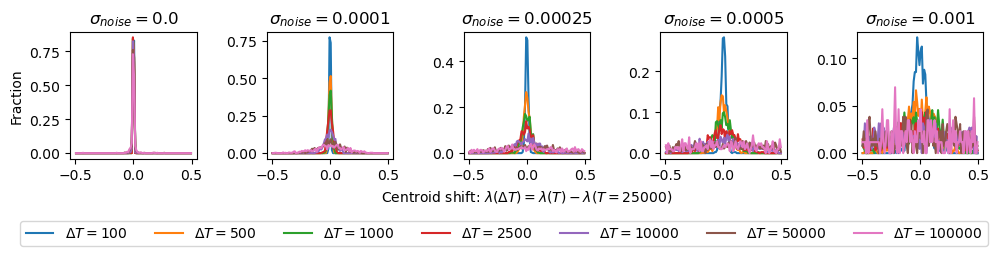

In [ ]:
trials = np.linspace(1, all_params.shape[3]-1, 3, dtype=int)
trials = [1, 5, 10, 25, 100, 500,1000]
print(trials)


f,axs = plt.subplots(1,5,figsize=(2*5,2.25))

for ns, noise in enumerate(noises):
    lambdas = all_params[ns, :, 0]
    init_lambda = lambdas[:,0]
    ax = axs[ns]

    if ns == 2:
        lines = []  # To store line objects and their labels


    for t, trial in enumerate(trials):
        del_lam = lambdas[:,trials[t]] - init_lambda
        del_lam = del_lam.reshape(-1)

        # Compute histogram data
        bin_edges = np.linspace(-0.5, 0.5, 101)
        counts, _ = np.histogram(del_lam, bins=bin_edges, density=True)

        # Get bin centers
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # Plot the histogram as a line
        line = ax.plot(bin_centers, counts/len(param_delta[0][0]), label=f'$\Delta T={trial*100}$')

        if ns == 2:
            lines.append(line[0])  # Collect line objects from subplot 3

    # ax.legend()
    if ns == 2:
        ax.set_xlabel('Centroid shift: $\lambda( \Delta T) = \lambda(T) - \lambda(T=25000)$')
    if ns == 0:
        ax.set_ylabel('Fraction')
    ax.set_title(f'$\sigma_{{noise}}={{{noise}}}$')

f.legend(handles=lines, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(trials))

f.tight_layout()
# f.savefig('./svgs/1D_drift_shift_frac.svg')

(64,)
(64,)
(64,)
(64,)


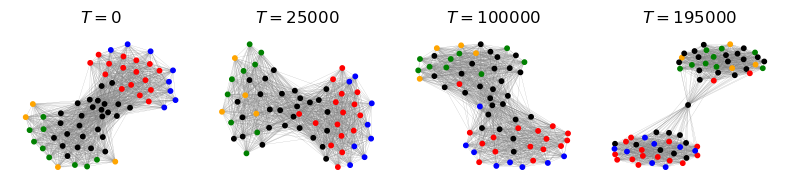

In [5]:
import networkx as nx
ns = 2
seed = 3
trials = [-1, 0, 750, 1700]
names = [0, 25000,25000 + 750 * 100, 25000 + 1700 * 100]

f, ax = plt.subplots(1, len(trials), figsize=(2 * len(trials), 2))

for t, trial in enumerate(trials):

    if trial == -1:
        lambda_values = np.linspace(-1, 1, 64)
    else:
        lambda_values = all_params[ns, seed, 0, trial]
    print(lambda_values.shape)

    # Compute the normalized correlation matrix
    norms = np.linalg.norm(lambda_values)
    cos_sim = np.outer(lambda_values, lambda_values) / (norms ** 2)
    correlation_matrix = normalize_values(cos_sim)

    # Create a graph
    G = nx.Graph()

    # Add nodes corresponding to each lambda value
    G.add_nodes_from(range(64))  # Nodes are numbered from 0 to 63

    # Determine node colors based on lambda values
    if t == 0:
        node_colors = []
        for value in lambda_values:
            if 0.25 < value < 0.75:
                node_colors.append('red')
            elif 0.75 <= value <= 1:
                node_colors.append('blue')
            elif -0.9 < value < -0.6:
                node_colors.append('green')
            elif -1 <= value <= -0.9:
                node_colors.append('orange')
            else:
                node_colors.append('black')

    # Add edges based on1correlation threshold
    threshold = 0.55
    # threshold = np.mean(correlation_matrix)
    for i in range(len(lambda_values)):
        for j in range(i + 1, len(lambda_values)):  # Only consider the upper triangle
            weight = 1 - correlation_matrix[i, j]
            if weight < threshold:
                # Use 1 - correlation as the weight for edges

                G.add_edge(i, j, weight=weight)

    # Compute positions with spring layout using edge weights
    pos = nx.spring_layout(G, seed=3, weight='weight')  # Integrate edge lengths
    # pos = nx.circular_layout(G)  # Integrate edge lengths
    # pos = nx.kamada_kawai_layout(G, weight='weight')

    # Plot the graph topology
    nx.draw(G, pos, ax=ax[t],
            with_labels=False,
            node_size=10,
            node_color=node_colors,
            font_size=1,
            font_color='black',
            edge_color='gray',
            width=0.1)

    ax[t].set_title(f"$T={names[t]}$")
f.tight_layout()
# f.savefig(f'./svgs/graph_com_thres{threshold}.svg')

$\lambda$
(0,)
(557, 30)
$\sigma$
(1,)
(559, 30)
$\alpha$
(2,)
(503, 30)
$\lambda$, $\sigma$
(0, 1)
(560, 30)
$\lambda$, $\alpha$
(0, 2)
(499, 30)
$\sigma$, $\alpha$
(1, 2)
(553, 30)
$\lambda$, $\sigma$, $\alpha$
(0, 1, 2)
(5407, 30)
$W_\pi$
(3,)
(719, 30)
$w_v$
(4,)
(709, 30)
$W_\pi$, $w_v$
(3, 4)
(677, 30)
$\lambda$, $\sigma$, $\alpha$, $W_\pi$, $w_v$
(0, 1, 2, 3, 4)
(6449, 30)


/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_95841/986638138.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  legend_ax = plt.subplot2grid((3, 4), (2, 3))


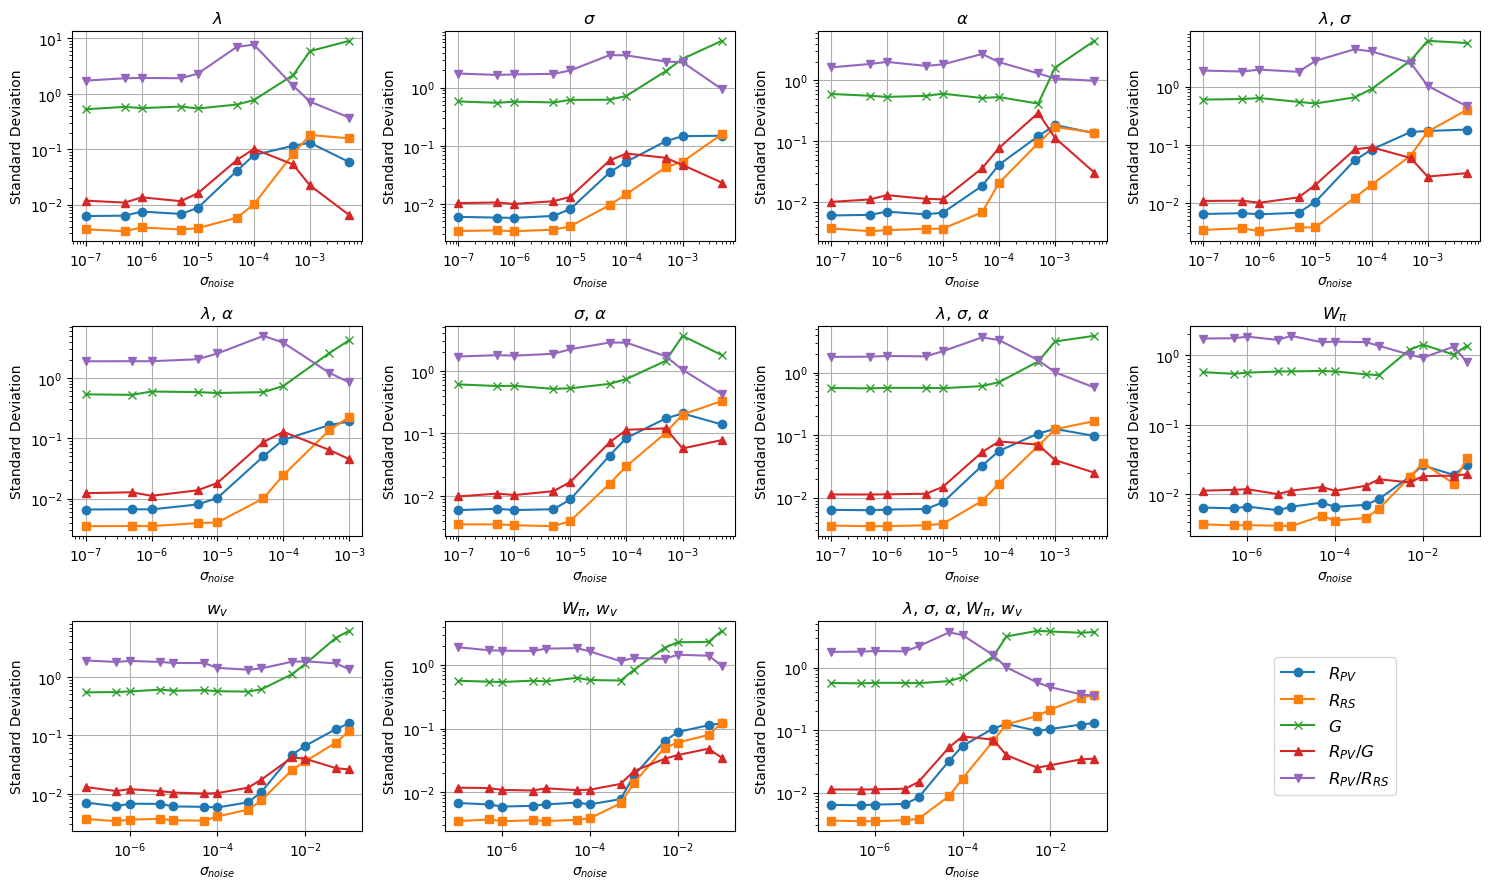

In [10]:

# Function to safely convert paramsindex to tuples
def safe_convert_paramsindex(x):
    if isinstance(x, str):
        return tuple(sorted(eval(x)))
    elif isinstance(x, list):
        return tuple(sorted(x))
    else:
        return x


import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(data_dir+'/csvs/drift_results_noise_all.csv')
df['paramsindex'] = df['paramsindex'].apply(safe_convert_paramsindex)

# Define the noise values you are interested in
noise_values_1 = [0.0, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
noise_values_2 = [0.0, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
slr = 0.0001

names_dict = {0: r'$\lambda$', 2: r'$\alpha$', 1: r'$\sigma$', 3: r'$W_\pi$', 4: r'$w_v$', }
params_indices = [[0], [1], [2], [0, 1], [0, 2], [1, 2], [0, 1, 2], [3], [4], [3, 4], [0, 1, 2, 3, 4]]  # [0],[1],[2],[0,1], [0,2],[1,2],[0,1,2],  [3], [4], [3, 4]
fig, axs = plt.subplots(3, 4, figsize=(15, 9))

for p, pidx in enumerate(params_indices):

    if p < 7:
        noise_values = noise_values_2
    else:
        noise_values = noise_values_1

    name_components = []
    for name in pidx:
        name_components.append(names_dict[name])
    name = ', '.join(name_components)
    print(name)

    params_index = tuple(sorted(pidx))
    print(params_index)

    # Filtering the dataframe for the given noise values
    filtered_df = df[df['noise'].isin(noise_values)]
    filtered_df = filtered_df[filtered_df['slr'] == slr]
    if len(pidx) < 3:
        filtered_df = filtered_df[filtered_df['paramsindex'] == params_index]

    small_value = 1e-7
    filtered_df['noise'] = filtered_df['noise'].replace({0.0: small_value})

    # Group by noise and calculate mean of var_pv and var_rc
    mean_std_values = filtered_df.groupby('noise')[['var_pv', 'var_rc', 'var_lat', 'var_gr']].mean().reset_index()
    print(filtered_df.shape)

    # Square the mean values to get variance
    mean_values = mean_std_values.copy()
    # mean_values[['var_pv', 'var_rc', 'var_lat', 'var_gr']] = mean_values[['var_pv', 'var_rc', 'var_lat', 'var_gr']] ** 2

    ax = axs[p // 4, p % 4]  # Access subplot
    # Create line plots for var_pv and var_rc
    ax.plot(mean_values['noise'], mean_values['var_pv'], '-o', label='$R_{PV}$')  # high
    ax.plot(mean_values['noise'], mean_values['var_rc'], '-s', label='$R_{RS}$')  # low
    # ax.plot(mean_values['noise'], mean_values['var_lat'], '-^', label='var_lat')
    ax.plot(mean_values['noise'], mean_values['var_gr'], '-x', label='$G$')  # low

    ax.plot(mean_values['noise'], mean_values['var_pv']/mean_values['var_gr'], '-^', label='$R_{PV}/G$')  # high
    ax.plot(mean_values['noise'], mean_values['var_pv']/mean_values['var_rc'], '-v', label='$R_{PV}/R_{RS}$') # high

    # Configure plot
    ax.set_xlabel(f'$\sigma_{{noise}}$')
    ax.set_ylabel('Standard Deviation')
    ax.set_title(name)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True)

# Add legend to the empty subplot (12th subplot)
axs[2][3].axis('off')  # Turn off the axis
handles, labels = axs[0, 0].get_legend_handles_labels()
legend_ax = plt.subplot2grid((3, 4), (2, 3))
legend_ax.axis('off')
legend_ax.legend(handles, labels, loc='center', fontsize=12)

fig.tight_layout()
# fig.savefig('./svgs/all_noise_var.svg')
plt.show()
